Note: in the current fixed charliecloud container scvelo is on version 0.2.2, update it via `pip install scvelo==0.2.3` to make sure to use scvelo's multicore support

In [1]:
DATA_DIR = '/storage/groups/ml01/workspace/louis.kuemmerle/projects/A1/data2/' # "./../"
DATA_VERSION = 'april21'

In [2]:
import os 
import numpy as np
import scipy as sci
from scipy import sparse
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl
from tqdm.notebook import tqdm
from datetime import datetime

import scanpy as sc
import anndata as ann
import scvelo as scv

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

sc.settings.verbosity = 3
sc.logging.print_versions()
print(f"scvelo=={scv.__version__}")

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              1.0.9
certifi             2020.12.05
cffi                1.14.4
chardet             4.0.0
cloudpickle         1.6.0
constants           NA
cycler              0.10.0
cython_runtime      NA
dask                2020.12.0
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
highs_wrapper       NA
idna                2.10
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.2
joblib              1.0.0
json5               NA
jsonschema          3.2.0
jupyter_server      1.2.1
jupyterlab_server   2.1.2
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg

# Iterative building of ldata
Somehow the kernel occasionally dies after several steps of building the ldata, therefore apply the following iterative save procedure:
- Load adata which is needed as reference for indices and delete all its info that is not needed
- Iterative extension of saved ldata:
    - if a saved ldata already exists: load an get sample ids that are already saved in ldata
    - for sample ids not saved:
        - load loom file as ldata_tmp
        - adjust indices of ldata_tmp according adata reference
        - add ldata_tmp to ldata 
        - save to disk (so we can start from there if the kernel died again)

In [3]:
def rename_idxs(ldata,sample_id,adata=None,sanity_check=True):
    """Rename the idxs in ldata such that they fit to the indices in adata
    
    adata has indices of the form '<sequence>-1-<sample_nr>', e.g.: 'AAACGCTGTTTGGGAG-1-17'
    ldata has indices of the form 'possorted_genome_bam_<sample_code>:<sequence>x', e.g.
    'possorted_genome_bam_EA7E9:AAAGTCCGTTTGAAAGx'
    Purpose of the function is to set indices in ldata to indices of adata where the inital
    indices have the same <sequence>. 
    To check that each sequence only occurs one time in ldata and one time in adata a sanity
    check is included. To further check that all sequences in ldata are given in adata another
    sanity check is included.
    
    Arguments
    ---------
    ldata: anndata object
        anndata with splicing info. Its indices will be renamed.
    sample_id: str
        name of sample to which ldata belongs to.
    adata: anndata object
        anndata with index name references.
    sanity_check: bool
        if True raise Errors if sanity checks are not fulfilled.
    """
    n_obs = len(adata.obs.loc[adata.obs['sample_id']==sample_id])
    a_idxs = list(adata.obs.loc[adata.obs['sample_id']==sample_id].index)
    obs = [o.rsplit("-")[0] for o in a_idxs]
    if sanity_check:
        sane = len(np.unique(obs)) == n_obs
        if not sane:
            raise ValueError("sequences in adata are not unique")
    
    n_lobs = len(ldata.obs)
    l_idxs = list(ldata.obs.index)
    lobs = [o.rsplit(":")[1][:-1] for o in l_idxs]
    if sanity_check:
        sane = len(np.unique(lobs)) == n_lobs
        if not sane:
            raise ValueError("sequences in ldata are not unique")
    if sanity_check:
        sane = len(l_idxs) >= len(a_idxs)
        if not sane:
            raise ValueError(f"n_obs in ldata {len(l_idxs)} smaller then n_obs in adata {len(a_idxs)}")
    
    if sanity_check:
        for o in obs:
            if not o in lobs:
                raise ValueError("Found sequence in adata that was not found in ldata")
    
    # get index of adata if sequence is in adata else get old index of ldata
    new_idxs = [a_idxs[obs.index(seq)] if seq in obs else l_idxs[lobs.index(seq)] for seq in lobs]
            
    ldata.obs.index = new_idxs
    
    
def clean_adata(adata,
                obs_keys=['sample_id'],
                var_keys=[],
                uns_keys=[],
                obsm_keys=[],
                varm_keys=[],
                inplace=True
                ):
    if inplace:
        a = adata
    else:
        a = adata.copy()
    for obs in [o for o in a.obs_keys() if not o in obs_keys]:
        del a.obs[obs]
    for var in [v for v in a.var_keys() if not v in var_keys]:
        del a.var[var]
    for uns in [u for u in a.uns_keys() if not u in uns_keys]:
        del a.uns[uns]
    for obsm in [om for om in a.obsm_keys() if not om in obsm_keys]:
        del a.obsm[obsm]
    for varm in [vm for vm in a.varm_keys() if not vm in varm_keys]:
        del a.varm[varm]
    if not inplace: 
        return a        

In [4]:
# Load reference adata
adata_path = DATA_DIR+f'cellxgene_{DATA_VERSION}_wSham.h5ad' 
adata = ann.read_h5ad(adata_path)
clean_adata(adata)
adata.X = sparse.csr_matrix(adata.X)
adata.X = 0

In [5]:
# Prepare infos and vars for iterative creation of ldata
ldata_path = DATA_DIR + 'cellxgene_loom_raw.h5ad'
existing_sample_ids = []
if os.path.exists(ldata_path):
    ldata = sc.read(ldata_path)
    existing_sample_ids = np.unique(ldata.obs['sample_id'])
    
# data of splicing info
loom_files = {}
base_path = "/storage/groups/bcf/projects/SingleCell/10x/projects/ertuerk/MCAO_vs_sham/rev5/velocyto/"
sample_ids = os.listdir(base_path)
for sample_id in sample_ids:
    files = os.listdir(base_path+sample_id)
    for file in files:
        if file[-5:] == '.loom': loom_files[sample_id] = base_path+sample_id+"/"+file    

In [6]:
# Iterative creation of cellxgene_loom_raw.h5ad
    # for the protocol: I ran with 6 cpus, 12GB memory for each and at sample 23 (of 32) an allocation error occured.
    # Then I rerun the procedure (it starts from sample 23 automatically) and at sample 9 (=31) again an allocation error occured.
    # So again, kernel restart for the last 2 samples, this time we reached the end, wuhu.
    # Update 11.02.21: the memory was the problem, at that time I thought I had 12GB/cpu_core = 72GB in total. 
    #                  It was only 12 GB in total.
missing_ids = [ID for ID in sample_ids if not(ID in existing_sample_ids)]
t0 = datetime.now()
for i,sample_id in enumerate(missing_ids):
    print(f"sample {sample_id} {i+1}/{len(missing_ids)} ({datetime.now()-t0})")
    ldata_tmp = ann.read_loom(loom_files[sample_id])
    ldata_tmp.var_names_make_unique()
    rename_idxs(ldata_tmp,sample_id,adata=adata,sanity_check=True)
    ldata_tmp.obs['sample_id'] = sample_id
    if sample_id == sample_ids[0]:
        ldata = ldata_tmp
    else:
        print(f"\t concatenate ({datetime.now()-t0})")
        ldata = ldata.concatenate(ldata_tmp)
    print(f"\t write ({datetime.now()-t0})")
    ldata.write(ldata_path)
    

### Now merge loom and cellxgene and save for: full set + neutrophils only
- merge
- save
- produce reduced adata with neutrophils and progenitors
    - umap
    - save

In [7]:
# Load reference adata
adata_path = DATA_DIR+f'cellxgene_{DATA_VERSION}_wSham.h5ad'
adata = ann.read_h5ad(adata_path)
if not sparse.issparse(adata.X):
    adata.X = sparse.csr_matrix(adata.X)

In [8]:
adata = scv.utils.merge(adata, ldata)
del ldata

In [9]:
del_vars = [
'Chromosome-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0-0', 
'Strand-1-0-0-0-0-0-0', 
'Chromosome-1-0-0-0-0-0', 
'Strand-1-0-0-0-0-0', 
'Chromosome-1-0-0-0-0', 
'Strand-1-0-0-0-0', 
'Chromosome-1-0-0-0', 
'Strand-1-0-0-0', 
'Chromosome-1-0-0', 
'Strand-1-0-0', 
'Chromosome-1-0', 
'Strand-1-0', 
'Chromosome-1', 
'Strand-1'
]

for v in del_vars:
    try:
        del adata.var[v]
    except:
        pass

print(adata)

AnnData object with n_obs × n_vars = 147347 × 17088
    obs: 'sample_id', 'batch', 'sample_name', 'region', 'condition', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'size_factors', 'leiden', 'leiden_high_res', 'leiden_res_3', 'leiden_res_4', 'S_score', 'G2M_score', 'phase', 'cell_types_old', 'annotated', 'cell_types', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'annotated_colors', 'cell_types_colors', 'condition_colors', "dendrogram_['leiden']", 'hvg', 'leiden', 'leiden_colors', 'leiden_high_res_colors', 'leiden_res_3_colors', 'leiden_res_4_colors', 'neighbors', 'pca', 'rank_genes_groups', 'region_colors', 'sample_name_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connec

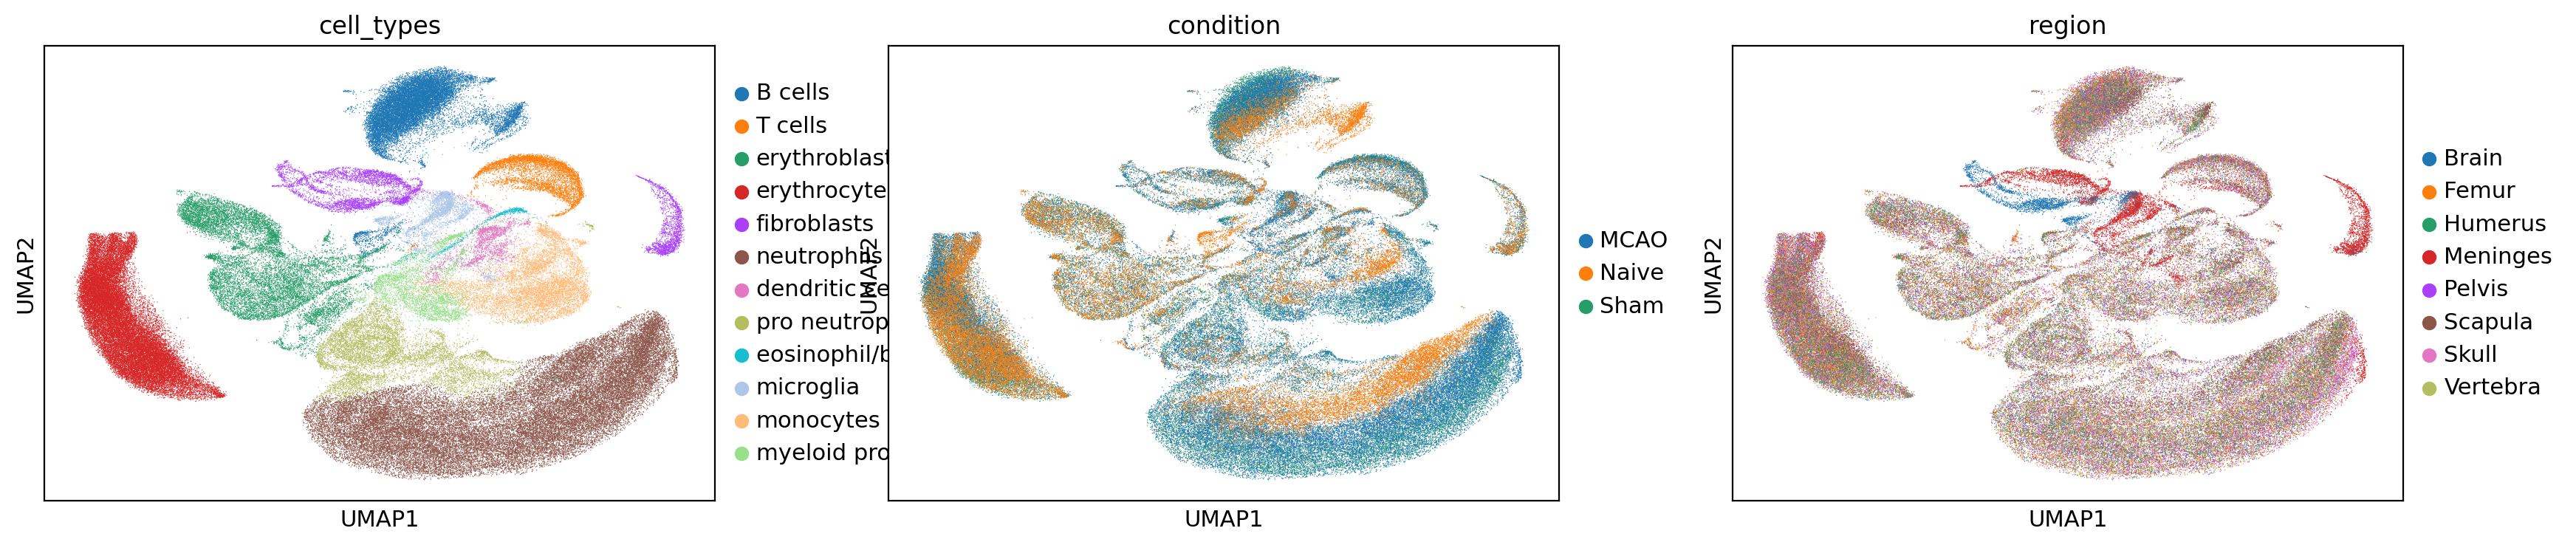

In [10]:
sc.pl.umap(adata, color=['cell_types','condition','region'],ncols=3)

In [11]:
adata.write(DATA_DIR+f"cellxgene_{DATA_VERSION}_wSham_loom_merged.h5ad")

#### I realized that `scv.merge` renames the obs indices. This is not handy for subsetting the dataset. Reassign the old indices:

In [12]:
adata_merged = sc.read(DATA_DIR+f"cellxgene_{DATA_VERSION}_wSham_loom_merged.h5ad")
adata = sc.read(DATA_DIR+f'cellxgene_{DATA_VERSION}_wSham.h5ad' )

In [13]:
# Small test that the obs ordering is the same
np.all(adata_merged.obs['n_counts'].values == adata.obs['n_counts'].values)

True

In [14]:
print(adata_merged.obs.index[:3])
print(adata.obs.index[:3])

Index(['AAACCCACATCATCTT', 'AAACCCACATTCACAG', 'AAACCCAGTACTCCCT'], dtype='object')
Index(['AAACCCACATCATCTT-1-0', 'AAACCCACATTCACAG-1-0', 'AAACCCAGTACTCCCT-1-0'], dtype='object', name='index')


In [15]:
adata_merged.obs.index = adata.obs.index

In [16]:
print(adata_merged.obs.index[:3])
print(adata.obs.index[:3])

Index(['AAACCCACATCATCTT-1-0', 'AAACCCACATTCACAG-1-0', 'AAACCCAGTACTCCCT-1-0'], dtype='object', name='index')
Index(['AAACCCACATCATCTT-1-0', 'AAACCCACATTCACAG-1-0', 'AAACCCAGTACTCCCT-1-0'], dtype='object', name='index')


In [17]:
adata_merged.write(DATA_DIR+f"cellxgene_{DATA_VERSION}_wSham_loom_merged.h5ad")